# Model Comparison

In [13]:
import json
import sys

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from src.llm_absa import OllamaABSA

# Add src to path
sys.path.insert(0, '../src')

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

from src.transformer_absa import TransformerABSA
from src.lexicon_absa import LexiconABSA

print("✓ Imports successful!")

✓ Imports successful!


## Load Test/Evaluation Data

In [14]:
# Load test samples

# Test data (25 sentences to analyze, quicker)
# with open('../data/test_samples.json', 'r') as f:
#     test_data = json.load(f)

# Evaluation data (108 sentences to analyze, slower, but reveals more information about each implementation)
with open('../data/evaluation_data.json', 'r') as f:
    test_data = json.load(f)

print(f"Loaded {len(test_data)} test samples")
print("\nExample test case:")
print(f"Text: {test_data[0]['text']}")
print(f"Expected: {test_data[0]['expected']}")

Loaded 108 test samples

Example test case:
Text: The pizza was very delicious but the service was terrible.
Expected: [{'aspect': 'pizza', 'sentiment': 'positive'}, {'aspect': 'service', 'sentiment': 'negative'}]


## Helper functions to normalize and match the results, for better overall performance

In [15]:
def normalize(aspect: str) -> str:
    """Simplify aspect names for fairer comparison."""
    aspect = aspect.lower().strip()
    # remove generic or context words the model might add
    for word in ["the", "a", "an", "app", "system", "team", "product", "item"]:
        aspect = aspect.replace(word, "")
    # clean up punctuation and extra spaces
    aspect = aspect.replace("-", " ").replace("_", " ")
    aspect = " ".join(aspect.split())
    return aspect.strip()


def aspect_match(expected: str, predicted: str) -> bool:
    """Match aspects leniently using normalization and substring logic."""
    e = normalize(expected)
    p = normalize(predicted)
    return e in p or p in e

def evaluate_results(predictions, expected):
    """Calculate accuracy metrics using flexible aspect matching."""
    correct_aspects = 0
    correct_sentiments = 0

    for exp in expected:
        exp_aspect = exp['aspect']
        exp_sent = exp['sentiment']

        # Check if any predicted aspect matches
        matched_pred = None
        for pred in predictions:
            if aspect_match(exp_aspect, pred.aspect):
                matched_pred = pred
                break

        if matched_pred:
            correct_aspects += 1
            if matched_pred.sentiment.lower() == exp_sent.lower():
                correct_sentiments += 1

    return {
        'total_expected': len(expected),
        'total_predicted': len(predictions),
        'correct_aspects': correct_aspects,
        'correct_sentiments': correct_sentiments
    }

## Initialize Analyzers

In [16]:
print("Initializing analyzers...")
lexicon_analyzer = LexiconABSA()
transformer_analyzer = TransformerABSA()
ollama_llm_analyzer = OllamaABSA()

print("✓ All analyzers ready!")

Initializing analyzers...
Loading model: yangheng/deberta-v3-base-absa-v1.1 (device: CPU)


C:\Users\ronom\AppData\Roaming\Python\Python313\site-packages\transformers\convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Device set to use cpu


 Connected to Ollama at http://localhost:11434
✓ All analyzers ready!


## Test Single Example

In [17]:
# Test on a single example
test_case = test_data[0]
text = test_case['text']
expected_aspects = [e['aspect'] for e in test_case['expected']]

print(f"Text: '{text}'")
print(f"\nExpected aspects: {expected_aspects}")

# --- Lexicon-Based ---
print("\n" + "=" * 60)
print("LEXICON-BASED RESULTS:")
print("=" * 60)
lexicon_results = lexicon_analyzer.analyze(text)
for r in lexicon_results:
    print(f"  {r.aspect:15} → {r.sentiment:10} (confidence: {r.confidence:.3f})")

# --- Transformer-Based ---
print("\n" + "=" * 60)
print("TRANSFORMER-BASED RESULTS:")
print("=" * 60)
transformer_results = transformer_analyzer.analyze(text, aspects=expected_aspects)
for r in transformer_results:
    print(f"  {r.aspect:15} → {r.sentiment:10} (confidence: {r.confidence:.3f})")

# --- Ollama-Based ---
print("\n" + "=" * 60)
print("Ollama-BASED RESULTS:")
print("=" * 60)
ollama_results = ollama_llm_analyzer.analyze(text)
for r in ollama_results:
    print(f"  {r.aspect:15} → {r.sentiment:10} (confidence: {r.confidence:.3f})")

# --- Expected ---
print("\n" + "=" * 60)
print("EXPECTED RESULTS:")
print("=" * 60)
for e in test_case['expected']:
    print(f"  {e['aspect']:15} → {e['sentiment']}")

Text: 'The pizza was very delicious but the service was terrible.'

Expected aspects: ['pizza', 'service']

LEXICON-BASED RESULTS:
  pizza           → positive   (confidence: 0.834)
  service         → negative   (confidence: 0.477)

TRANSFORMER-BASED RESULTS:
  pizza           → positive   (confidence: 0.997)
  service         → negative   (confidence: 0.994)

Ollama-BASED RESULTS:
 Attempt 1/2...
 Got response from model
 Raw content: {
    "aspects": [
        {"aspect": "pizza", "sentiment": "positive", "confidence": 0.95},
        {"aspect": "service", "sentiment": "negative", "confidence": 0.90}
    ]
}...
  Found 2 aspects
  pizza           → positive   (confidence: 0.950)
  service         → negative   (confidence: 0.900)

EXPECTED RESULTS:
  pizza           → positive
  service         → negative


## Run Full Comparison

In [18]:
# Run on all samples
lexicon_metrics = {'correct_aspects': 0, 'correct_sentiments': 0,
                   'total_expected': 0, 'total_predicted': 0}

transformer_metrics = {'correct_aspects': 0, 'correct_sentiments': 0,
                       'total_expected': 0, 'total_predicted': 0}

ollama_metrics = {'correct_aspects': 0, 'correct_sentiments': 0,
                  'total_expected': 0, 'total_predicted': 0}

results_list = []

for i, test_case in enumerate(test_data):
    text = test_case['text']
    expected = test_case['expected']

    # Get predictions from all analyzers
    lex_results = lexicon_analyzer.analyze(text)
    trans_results = transformer_analyzer.analyze(text)
    ollama_results = ollama_llm_analyzer.analyze(text)

    # Evaluate
    lex_eval = evaluate_results(lex_results, expected)
    trans_eval = evaluate_results(trans_results, expected)
    ollama_eval = evaluate_results(ollama_results, expected)

    # Store results
    results_list.append({
        'text': text,
        'lexicon_correct': lex_eval['correct_sentiments'],
        'transformer_correct': trans_eval['correct_sentiments'],
        'ollama_correct': ollama_eval['correct_sentiments'],
        'total_aspects': len(expected)
    })

    # Aggregate metrics
    for key in ['correct_aspects', 'correct_sentiments', 'total_expected', 'total_predicted']:
        lexicon_metrics[key] += lex_eval[key]
        transformer_metrics[key] += trans_eval[key]
        ollama_metrics[key] += ollama_eval[key]

    if (i + 1) % 5 == 0:
        print(f"Processed {i + 1}/{len(test_data)} samples...")

print("\n✓ Evaluation complete!")


 Attempt 1/2...
 Got response from model
 Raw content: {
    "aspects": [
        {"aspect": "pizza", "sentiment": "positive", "confidence": 0.95},
        {"aspect": "service", "sentiment": "negative", "confidence": 0.90}
    ]
}...
  Found 2 aspects
 Attempt 1/2...
 Got response from model
 Raw content: {
    "aspects": [
        {
            "aspect": "food",
            "sentiment": "negative",
            "confidence": 0.95
        }
    ]
}...
  Found 1 aspects
 Attempt 1/2...
 Got response from model
 Raw content: {
    "aspects": [
        {
            "aspect": "service",
            "sentiment": "neutral",
            "confidence": 0.75
        }
    ]
}...
  Found 1 aspects
 Attempt 1/2...
 Got response from model
 Raw content: {
    "aspects": [
        {"aspect": "room", "sentiment": "neutral", "confidence": 0.85},
        {"aspect": "bathroom", "sentiment": "negative", "confidence": 0.95}
    ]
}...
  Found 2 aspects
 Attempt 1/2...
 Got response from model
 Raw content

## Display Summary Statistics

In [19]:
# Calculate percentages
lex_aspect_acc = lexicon_metrics['correct_aspects'] / lexicon_metrics['total_expected'] * 100
lex_sent_acc = lexicon_metrics['correct_sentiments'] / lexicon_metrics['total_expected'] * 100

trans_aspect_acc = transformer_metrics['correct_aspects'] / transformer_metrics['total_expected'] * 100
trans_sent_acc = transformer_metrics['correct_sentiments'] / transformer_metrics['total_expected'] * 100

ollama_aspect_acc = ollama_metrics['correct_aspects'] / ollama_metrics['total_expected'] * 100
ollama_sent_acc = ollama_metrics['correct_sentiments'] / ollama_metrics['total_expected'] * 100

# Create summary DataFrame
summary_data = {
    'Implementation': ['Lexicon-Based', 'Transformer-Based', 'Ollama-Based'],
    'Aspect Accuracy (%)': [lex_aspect_acc, trans_aspect_acc, ollama_aspect_acc],
    'Sentiment Accuracy (%)': [lex_sent_acc, trans_sent_acc, ollama_sent_acc],

    'Total Predictions': [lexicon_metrics['total_predicted'],
                          transformer_metrics['total_predicted'],
                          ollama_metrics['total_predicted']],

    'Correct Sentiments': [lexicon_metrics['correct_sentiments'],
                           transformer_metrics['correct_sentiments'],
                           ollama_metrics['correct_sentiments']]
}

summary_df = pd.DataFrame(summary_data)
print("\nSUMMARY STATISTICS")
print("=" * 80)
print(summary_df.to_string(index=False))


SUMMARY STATISTICS
   Implementation  Aspect Accuracy (%)  Sentiment Accuracy (%)  Total Predictions  Correct Sentiments
    Lexicon-Based            64.795918               27.551020                186                  54
Transformer-Based            77.040816               65.816327                692                 129
     Ollama-Based            82.653061               74.489796                207                 146


## Visualize Results - Bar Chart

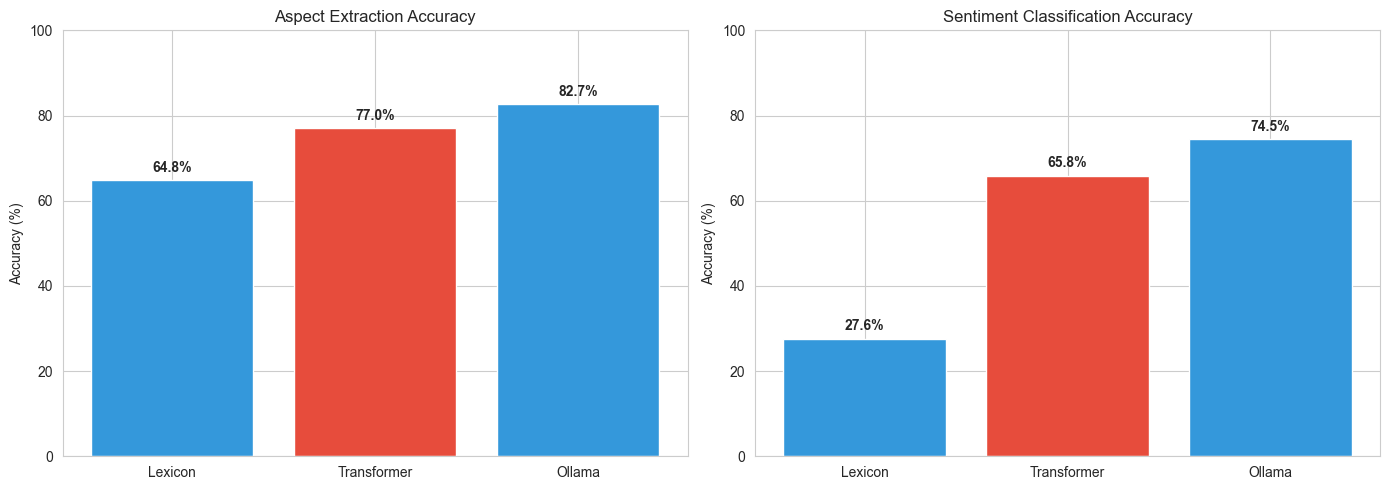

In [20]:
# Create comparison bar chart
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Aspect Accuracy
aspects_data = ['Lexicon', 'Transformer', 'Ollama']
aspects_values = [lex_aspect_acc, trans_aspect_acc, ollama_aspect_acc]
axes[0].bar(aspects_data, aspects_values, color=['#3498db', '#e74c3c'])
axes[0].set_ylabel('Accuracy (%)')
axes[0].set_title('Aspect Extraction Accuracy')
axes[0].set_ylim([0, 100])
for i, v in enumerate(aspects_values):
    axes[0].text(i, v + 2, f'{v:.1f}%', ha='center', fontweight='bold')

# Sentiment Accuracy
sentiment_data = ['Lexicon', 'Transformer', 'Ollama']
sentiment_values = [lex_sent_acc, trans_sent_acc, ollama_sent_acc]
axes[1].bar(sentiment_data, sentiment_values, color=['#3498db', '#e74c3c'])
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Sentiment Classification Accuracy')
axes[1].set_ylim([0, 100])
for i, v in enumerate(sentiment_values):
    axes[1].text(i, v + 2, f'{v:.1f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

## Per-Sample Comparison


PER-SAMPLE RESULTS (First 10 samples)


,text,lexicon_correct,transformer_correct,ollama_correct,total_aspects,lexicon_accuracy,transformer_accuracy,ollama_accuracy
0,The pizza was very delicious but the service w...,2,2,2,2,100.000000,100.0,100.0
1,The food was not good :(,0,1,1,1,0.000000,100.0,100.0
2,The service isn't bad.,1,1,0,1,100.000000,100.0,0.0
3,The room was okay but the bathroom was dirty.,1,1,1,2,50.000000,50.0,50.0
4,The phone has great battery life but the camer...,2,2,2,2,100.000000,100.0,100.0
5,The laptop runs fast but the fan is so loud th...,1,2,1,2,50.000000,100.0,50.0
6,"The movie was long and boring, but the soundtr...",2,2,2,2,100.000000,100.0,100.0
7,"The coffee temperature was too hot at first, b...",1,2,2,2,50.000000,100.0,100.0
8,"The restaurant decor is nice, but the food is ...",1,3,3,3,33.333333,100.0,100.0
9,"The service was absolutely outstanding, and th...",2,2,2,2,100.000000,100.0,100.0


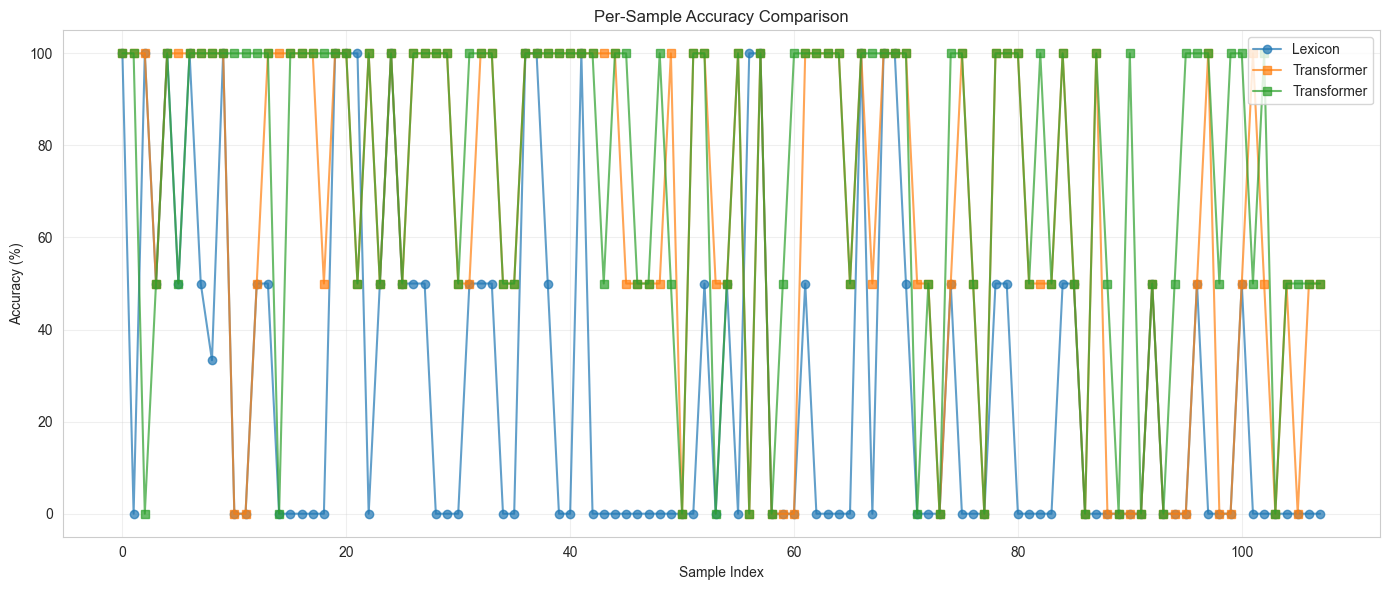

In [21]:
# Create DataFrame for detailed comparison
results_df = pd.DataFrame(results_list)
results_df['lexicon_accuracy'] = results_df['lexicon_correct'] / results_df['total_aspects'] * 100
results_df['transformer_accuracy'] = results_df['transformer_correct'] / results_df['total_aspects'] * 100
results_df['ollama_accuracy'] = results_df['ollama_correct'] / results_df['total_aspects'] * 100

print("\nPER-SAMPLE RESULTS (First 10 samples)")
print("=" * 80)
display(results_df.head(10))

# Plot per-sample comparison
plt.figure(figsize=(14, 6))
x = range(len(results_df))
plt.plot(x, results_df['lexicon_accuracy'], label='Lexicon', marker='o', alpha=0.7)
plt.plot(x, results_df['transformer_accuracy'], label='Transformer', marker='s', alpha=0.7)
plt.plot(x, results_df['ollama_accuracy'], label='Transformer', marker='s', alpha=0.7)
plt.xlabel('Sample Index')
plt.ylabel('Accuracy (%)')
plt.title('Per-Sample Accuracy Comparison')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Identify Challenging Cases

In [22]:
# Find cases where all three models struggled
challenging_cases = results_df[
    (results_df['lexicon_accuracy'] < 100) &
    (results_df['transformer_accuracy'] < 100) &
    (results_df['ollama_accuracy'] < 100)
    ]

print(f"\nChallenging Cases (both models < 100%): {len(challenging_cases)}")
print("=" * 80)

for idx in challenging_cases.index[:5]:  # Show first 5
    print(f"\nSample {idx}:")
    print(f"Text: {test_data[idx]['text']}")
    print(f"Lexicon accuracy: {results_df.loc[idx, 'lexicon_accuracy']:.1f}%")
    print(f"Transformer accuracy: {results_df.loc[idx, 'transformer_accuracy']:.1f}%")
    print(f"Ollama accuracy: {results_df.loc[idx, 'ollama_accuracy']:.1f}%")
    print(f"Expected: {test_data[idx]['expected']}")


Challenging Cases (both models < 100%): 35

Sample 3:
Text: The room was okay but the bathroom was dirty.
Lexicon accuracy: 50.0%
Transformer accuracy: 50.0%
Ollama accuracy: 50.0%
Expected: [{'aspect': 'room', 'sentiment': 'neutral'}, {'aspect': 'bathroom', 'sentiment': 'negative'}]

Sample 23:
Text: The packaging was impressive, but the product inside was broken.
Lexicon accuracy: 50.0%
Transformer accuracy: 50.0%
Ollama accuracy: 50.0%
Expected: [{'aspect': 'packaging', 'sentiment': 'positive'}, {'aspect': 'product', 'sentiment': 'negative'}]

Sample 25:
Text: The keyboard feels smooth, but some keys stopped working after a week.
Lexicon accuracy: 50.0%
Transformer accuracy: 50.0%
Ollama accuracy: 50.0%
Expected: [{'aspect': 'keyboard', 'sentiment': 'negative'}, {'aspect': 'keys', 'sentiment': 'negative'}]

Sample 30:
Text: The manager was polite and resolved my issue instantly.
Lexicon accuracy: 0.0%
Transformer accuracy: 50.0%
Ollama accuracy: 50.0%
Expected: [{'aspect': 'manager

## Strengths Analysis

Lexicon better: 2 cases (1.9%)
Transformer better: 60 cases (55.6%)
Ollama better: 72 cases (66.7%)
Equal performance: 46 cases (42.6%)


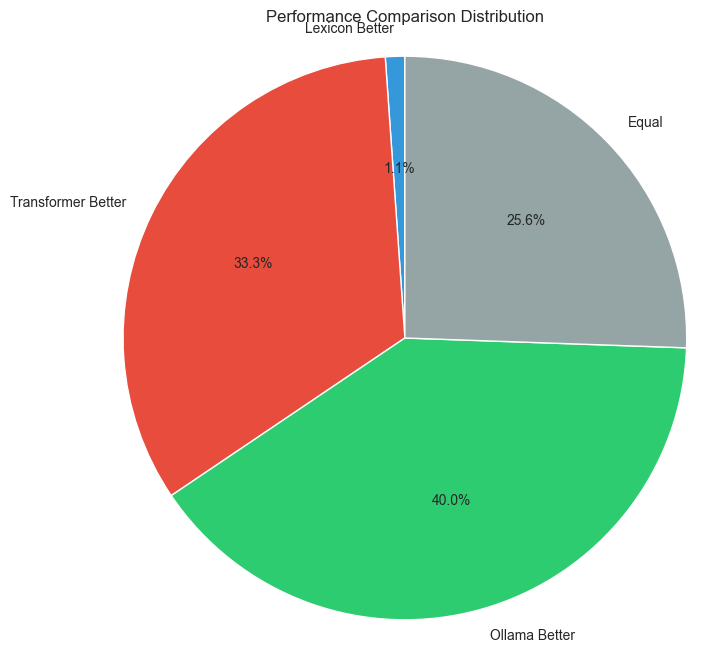

In [23]:
# Cases where lexicon outperforms
lexicon_better = results_df[
    results_df['lexicon_accuracy'] > results_df['transformer_accuracy']
]

# Cases where transformer outperforms
transformer_better = results_df[
    results_df['transformer_accuracy'] > results_df['lexicon_accuracy']
]

# Cases where ollama outperforms
ollama_better = results_df[
    (results_df['ollama_accuracy'] > results_df['lexicon_accuracy']) |
    (results_df['ollama_accuracy'] > results_df['transformer_accuracy'])
]

# Calculate equal performance (neither is better)
equal_performance = len(results_df) - len(lexicon_better) - len(transformer_better)

print(f"Lexicon better: {len(lexicon_better)} cases ({len(lexicon_better) / len(results_df) * 100:.1f}%)")
print(f"Transformer better: {len(transformer_better)} cases ({len(transformer_better) / len(results_df) * 100:.1f}%)")
print(f"Ollama better: {len(ollama_better)} cases ({len(ollama_better) / len(results_df) * 100:.1f}%)")
print(f"Equal performance: {equal_performance} cases ({equal_performance / len(results_df) * 100:.1f}%)")

# Visualize
labels = ['Lexicon Better', 'Transformer Better', 'Ollama Better', 'Equal']
sizes = [len(lexicon_better), len(transformer_better), len(ollama_better), equal_performance]
colors = ['#3498db', '#e74c3c', '#2ecc71', '#95a5a6']  # Added 4th color for Ollama

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Performance Comparison Distribution')
plt.axis('equal')
plt.show()

## Conclusion and Insights

In [24]:
print("KEY INSIGHTS")
print("=" * 80)
print(f"""
1. Overall Performance:
   - Lexicon Sentiment Accuracy: {lex_sent_acc:.2f}%
   - Transformer Sentiment Accuracy: {trans_sent_acc:.2f}%
   - Ollama Sentiment Accuracy: {ollama_sent_acc:.2f}%
   - Winner: {max([('Lexicon', lex_sent_acc), ('Transformer', trans_sent_acc), ('Ollama', ollama_sent_acc)], key=lambda x: x[1])[0]}

2. Aspect Extraction:
   - Lexicon found: {lexicon_metrics['total_predicted']} aspects
   - Transformer found: {transformer_metrics['total_predicted']} aspects
   - Ollama found: {ollama_metrics['total_predicted']} aspects
   - Expected: {lexicon_metrics['total_expected']} aspects

3. Strengths:
   - Lexicon: {len(lexicon_better)} cases where it outperformed ({len(lexicon_better) / len(results_df) * 100:.1f}%)
   - Transformer: {len(transformer_better)} cases where it outperformed ({len(transformer_better) / len(results_df) * 100:.1f}%)
   - Ollama: {len(ollama_better)} cases where it outperformed ({len(ollama_better) / len(results_df) * 100:.1f}%)

4. Challenging Cases:
   - {len(challenging_cases)} cases where all methods struggled ({len(challenging_cases) / len(results_df) * 100:.1f}%)
""")

KEY INSIGHTS

1. Overall Performance:
   - Lexicon Sentiment Accuracy: 27.55%
   - Transformer Sentiment Accuracy: 65.82%
   - Ollama Sentiment Accuracy: 74.49%
   - Winner: Ollama

2. Aspect Extraction:
   - Lexicon found: 186 aspects
   - Transformer found: 692 aspects
   - Ollama found: 207 aspects
   - Expected: 196 aspects

3. Strengths:
   - Lexicon: 2 cases where it outperformed (1.9%)
   - Transformer: 60 cases where it outperformed (55.6%)
   - Ollama: 72 cases where it outperformed (66.7%)

4. Challenging Cases:
   - 35 cases where all methods struggled (32.4%)

